# 5. Linear Systems

## Preamble

In [1]:
import numpy as np
from scipy.integrate import odeint
from scipy.integrate import quad
from scipy.interpolate import InterpolatedUnivariateSpline as interpolate
from scipy.optimize import root
from scipy.misc import derivative
import scipy.linalg as lg

# install "numdifftools" with 'conda install numdifftools'
from numdifftools import Jacobian

import sympy as sp
import fractions as fra

from ipywidgets import interact

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import matplotlib as mpl
import matplotlib.pyplot as plt

import matplotlib.ticker as ticker
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
%run -i "rcParameters.py"
from mpl_toolkits.mplot3d import Axes3D

plt.rcParams["font.family"]='Times New Roman'
plt.rcParams["mathtext.fontset"]='stix';

In [3]:
# set fontsize in markdown cells
from IPython.core.display import display, HTML, Latex
display(HTML("<style>.rendered_html { font-size: 16px; }</style>"))

## Utility functions

In [4]:
# find fixed poits FP and their stability sFP
# input: function f(x;r) ; x_min,x_max, Nx (# of division points); parameter r
# output: [Sfp=stable FPs, Ufp=unstable FPs]
def fP(f,x_min,x_max,r,Nx=40,eps=1e-6):
    x = np.linspace(x_min,x_max,Nx)
    f_ = lambda x,r: interpolate(x,f(x,r))
    FP = f_(x,r).roots()
    print(FP)
    Sfp = []; Ufp = []
    for x0 in FP:
        dFP = derivative(f,x0,dx=eps,args=(r,))
        if dFP < 0:
            Sfp = np.append(Sfp,x0)
        else:
            Ufp = np.append(Ufp,x0)
    return [Sfp,Ufp]

In [5]:
# Phase portrait: streamplot X,Y,Vx=dx/dt,Vy=dy/dt
def PP_2d(x1,x2,y1,y2,f1,f2,ax,nx=100,ny=100,dens=[1,1],lw=1,col='k'):
    ax = ax or plt.gca()
    x = np.linspace(x1,x2,nx)
    y = np.linspace(y1,y2,ny)
    X,Y = np.meshgrid(x,y)
    U = f1(X,Y); V = f2(X,Y)
    ax.streamplot(X,Y,U,V,density=dens,
                 linewidth=lw,color=col,arrowstyle='->')
    return ax

# Phase portrait: streamlines through selected points
def PP_2d_sp(x1,x2,y1,y2,f1,f2,seed_points,ax,nx=100,ny=100,dens=[1,1],lw=1,col='k'):
    ax = ax or plt.gca()
    x = np.linspace(x1,x2,nx)
    y = np.linspace(y1,y2,ny)
    X,Y = np.meshgrid(x,y)
    U = f1(X,Y); V = f2(X,Y)    
    ax.streamplot(X,Y,U,V,density=dens,start_points=seed_points.T,
                 linewidth=lw,color=col,arrowstyle='->')
    return ax    

# Plot steamlines defined by eigenvector directions
def PP_evd(x1,x2,y1,y2,f1,f2,x0,ax,nx=100,ny=100,dens=[1,1],lw=1,col='r'):
    ax = ax or plt.gca()
# calculate Jacobian at FP x0
    J_mat = Jacobian(lambda x: np.array([f1(x[0],x[1]),f2(x[0],x[1])]))
    A = J_mat(x0)
    mu, U = lg.eig(A)
# streamlines through the eigendirections
    PP_2d_sp(x1,x2,y1,y2,f1,f2,np.array([U[0],U[1]]),ax,col='r',dens=d0)
    PP_2d_sp(x1,x2,y1,y2,f1,f2,np.array([-U[0],-U[1]]),ax,col='r',dens=d0)
    
    return ax

In [6]:
# Bifurcation diagram: x vs r
def BF_diag(f,x1,x2,r1,r2,nx=80,nr=80,title='',x_lab='$r$',y_lab='$x^\star$'):
    fx = lambda x,r: derivative(f,x,dx=1e-6,args=(r,))
    x=np.linspace(x1,x2,nx)
    r=np.linspace(r1,r2,nr)
    R,X = np.meshgrid(r,x)
    Z = f(X,R)
    Zx= fx(X,R)
    Zu= np.ma.masked_where(Zx<0,Z)
    Zs= np.ma.masked_where(Zx>0,Z)
    fig, ax=plt.subplots(figsize=(8,5))
    cnt_S=ax.contour(R,X,Zs,levels=[0],colors='k',linewidths=3)
    cnt_U=ax.contour(R,X,Zu,levels=[0],colors='k',linewidths=3,linestyles='dashed')
    ax.grid()
    ax.set_xlabel(x_lab)
    ax.set_ylabel(y_lab)
    ax.set_title(title,color='b')
    plt.show()

In [7]:
# interactive Streamline plot: x(t;r)
def int_xtr(f,t_max,dx,dr,FP0,Ng=40,dens=[0.5,1],title='',y_lab=r'$\theta$'):
    t = np.linspace(0,t_max,Ng)
    x = np.linspace(dx[0],dx[1],Ng)
    X,Y = np.meshgrid(t,x)
    @interact(r=(dr[0],dr[1],dr[2]),grid=False)
    def update(r=dr[0],grid=False):
        [Sx0,Ux0]=fP(f,dx[0],dx[1],r)
        # plot the slope field 
        fig, ax0=plt.subplots(figsize=(8,5))
        ax0.streamplot(X,Y, 1+0*X,f(Y,r),density=dens,
                      linewidth=1,color='k',arrowstyle='->')

        for x0 in Sx0:
            ax0.hlines(x0,0,t_max,colors='r',ls='-',lw=2)
        for x0 in Ux0:
            ax0.hlines(x0,0,t_max,colors='b',ls='--',lw=2)

        ax0.grid(grid)  
        ax0.set_xlim(0,t_max)
        ax0.set_ylim(dx)
        ax0.set_xlabel('$t$')
        ax0.set_ylabel(y_lab)
        ax0.set_title(title,color='b')
        plt.show()

In [8]:
# set minor tick marks on/off; default on
def m_tick_on():
    plt.rcParams['xtick.minor.visible'] = True
    plt.rcParams['ytick.minor.visible'] = True
def m_tick_off():
    plt.rcParams['xtick.minor.visible'] = False
    plt.rcParams['ytick.minor.visible'] = False
    
m_tick_on()

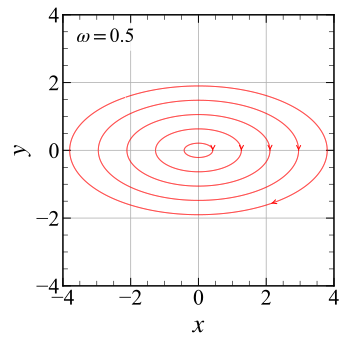

In [9]:
# phase portrait
w=0.5

x1 = -4; x2 = 4
y1 = -4; y2 = 4
f1 = lambda x,y: y 
f2 = lambda x,y: -w**2*x
ppx = np.linspace(x1+0.2,x2-0.2,10)
ppy = np.zeros(len(ppx))
pp0 = np.array([ppx,ppy])

fig_pp_HO, ax = plt.subplots(figsize=(5,5))
# PP_2d(x1,x2,y1,y2,f1,f2,ax,dens=0.5)
PP_2d_sp(x1,x2,y1,y2,f1,f2,pp0,ax,col='r',dens=25)
ax.set_aspect('equal')
ax.set_xlim(x1,x2)
ax.set_ylim(y1,y2)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')

ax.text(0.05,0.9,r'$\omega =$'+str(np.round(w,2)),fontsize=20,transform=ax.transAxes,
        bbox=dict(fc='w',ec='w',alpha=0.8))

ax.grid()
plt.show()

## 5.1.1 Harmonic oscillator

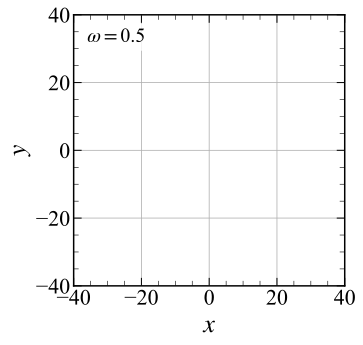

In [15]:
# phase portrait
w=0.5

x11 = -40; x22 = 40
y11 = -40; y22 = 40
f1 = lambda x1,x2,y1,y2: x2 
f2 = lambda x1,x2,y1,y2: w**2*x1 + 2*w*y2
f3 = lambda x1,x2,y1,y2: y2 
f4 = lambda x1,x2,y1,y2: w**2*y1 - 2*w*x2
ppx = np.linspace(x11+0.2,x22-0.2,10)
ppy = np.zeros(len(ppx))
pp0 = np.array([ppx,ppy])

fig_pp_HO, ax = plt.subplots(figsize=(5,5))
# PP_2d(x1,x2,y1,y2,f1,f2,ax,dens=0.5)
#PP_2d_sp(x11,x22,y11,y22,f1,f2,f3,f4,pp0,ax,col='r',dens=25)
ax.set_aspect('equal')
ax.set_xlim(x11,x22)
ax.set_ylim(y11,y22)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')

ax.text(0.05,0.9,r'$\omega =$'+str(np.round(w,2)),fontsize=20,transform=ax.transAxes,
        bbox=dict(fc='w',ec='w',alpha=0.8))

ax.grid()
plt.show()

## 5.1.2   $ \; \dot{x}=ax$, $\dot{y}=-y$

In [16]:
# phase portrait
x1 = -5; x2 = 5
y1 = -5; y2 = 5
f2 = lambda x,y: -y
d0 = 2

@interact(a=(-2,2,0.25),grid=True)
def update(a=-2,grid=True):
    f1 = lambda x,y: a*x 
    ppx = np.linspace(x1,x2,15)
    ppy = np.linspace(y1,y2,15)
    pp1 = np.ones(len(ppx))
    fig_512, ax = plt.subplots(figsize=(5,5))
#     PP_2d(x1,x2,y1,y2,f1,f2,ax,dens=0.5)
    PP_2d_sp(x1,x2,y1,y2,f1,f2,np.array([ppx,pp1*y1]),ax,col='k',dens=d0)
    PP_2d_sp(x1,x2,y1,y2,f1,f2,np.array([ppx,pp1*y2]),ax,col='k',dens=d0)
    PP_2d_sp(x1,x2,y1,y2,f1,f2,np.array([pp1*x1,ppy]),ax,col='k',dens=d0)
    PP_2d_sp(x1,x2,y1,y2,f1,f2,np.array([pp1*x2,ppy]),ax,col='k',dens=d0)
# streamlines along eigenvector directions
    PP_evd(x1,x2,y1,y2,f1,f2,[0,0],ax)

    ax.set_aspect('equal')
    ax.set_xlim(x1,x2)
    ax.set_ylim(y1,y2)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.grid(grid)
    plt.show()

interactive(children=(FloatSlider(value=-2.0, description='a', max=2.0, min=-2.0, step=0.25), Checkbox(value=T…

## 5.2.1 Initial value problem

Consider the linear 2D system $\dot{x}=x+y$, $\dot{y}=4x-2y$, with initial condition $(x_0,y_0)=(2,-3)$.

### Solve the initial value problem

#### Use `scipy.linalg` for numerical calculations

In [11]:
A  = np.array([[1,1],[4,-2]])
X0 = np.array([2,-3]) 
X  = lambda t: np.dot(lg.expm(A*t),X0)

#### Use `sympy` for symbolic calculations

In [12]:
A_  = sp.Matrix([[1,1],[4,-2]]); display(A_)
X0_ = sp.Matrix([2,-3])

Matrix([
[1,  1],
[4, -2]])

In [13]:
# find eigenvalues of A_
mu_ = list(A_.eigenvals()); mu_

[2, -3]

In [14]:
t = sp.symbols('t',nonnegative=True)
X_ = lambda t: sp.exp(A_*t)*X0_
X_(t)

Matrix([
[  exp(2*t) + exp(-3*t)],
[exp(2*t) - 4*exp(-3*t)]])

In [15]:
[display(X_(t).n(6)) for t in np.arange(5)];

Matrix([
[ 2.0],
[-3.0]])

Matrix([
[7.43884],
[7.18991]])

Matrix([
[54.6006],
[54.5882]])

Matrix([
[403.429],
[403.428]])

Matrix([
[2980.96],
[2980.96]])

### Calculate eigensystem (eigenvalues, eigenvectors) of $A$

#### Use `scipy.linalg` for numerical calculations

In [16]:
mu,U=lg.eig(A)
# eigenvalues & eigenvectors
[print(mu.real[j],': ',U[:,j]) for j in [0,1]];

2.0 :  [0.70710678 0.70710678]
-3.0 :  [-0.24253563  0.9701425 ]


In [17]:
# check the identity A.U=U.L
L = np.diag(mu.real)
np.dot(A,U)-np.dot(U,L)

array([[0., 0.],
       [0., 0.]])

#### Use `sympy` for symbolic calculations

In [18]:
# eigenvalues & eigenvectors of A
eig_sys = A_.eigenvects()
mu_ = [elem[0] for elem in eig_sys];
V_  = [elem[2][0] for elem in eig_sys];
L_  = sp.diag(mu_,unpack=True);
U_  = sp.Matrix([sp.flatten(v) for v in V_]);

In [19]:
# check that X(t)=U.exp(L.t).inv(U).X0
U_*sp.exp(L_*t)*U_.inv()*X0_

Matrix([
[  exp(2*t) + exp(-3*t)],
[exp(2*t) - 4*exp(-3*t)]])

In [20]:
# find exp(l_i*t)*v_i, i=1,2
[display(sp.exp(mu*t)*v) for mu,v in zip(mu_,V_)];

Matrix([
[-exp(-3*t)/4],
[   exp(-3*t)]])

Matrix([
[exp(2*t)],
[exp(2*t)]])

### Plot solution

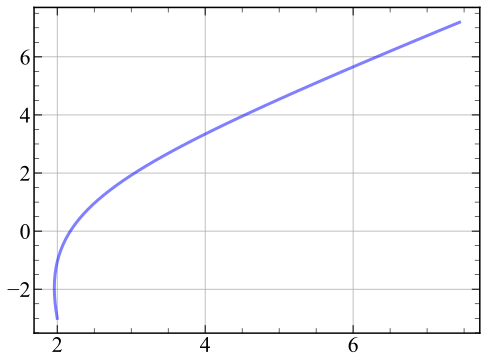

In [21]:
# plot trajectory {x(t),y(t)} for IC {x0,y0}
xt = sp.lambdify(t,X_(t)[0])
yt = sp.lambdify(t,X_(t)[1])
tt = np.linspace(0,1,50)
xx_ = [xt(t) for t in tt]
yy_ = [yt(t) for t in tt]
fig, ax=plt.subplots()
ax.plot(xx_,yy_,'b-',lw=3,alpha=0.5)
ax.grid()
plt.show()

### Phase portrait

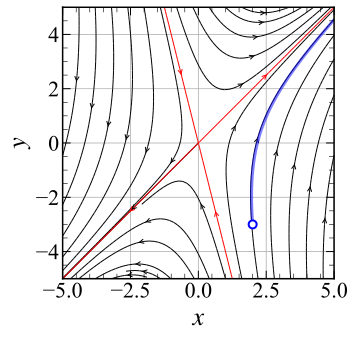

In [22]:
# phase portrait
x1 = -5; x2 = 5
y1 = -5; y2 = 5
f1 = lambda x,y: x+y 
f2 = lambda x,y: 4*x-2*y

d0=2; col='k'
dx0=0.6; dy0=0.5
ppx = np.arange(x1,x2,dx0)
ppy = np.arange(y1,y2,dy0)
pp1 = np.ones(len(ppx))

fig_521, ax = plt.subplots(figsize=(5,5))
# PP_2d(x1,x2,y1,y2,f1,f2,ax,dens=0.5)
PP_2d_sp(x1,x2,y1,y2,f1,f2,np.array([ppx,pp1*y1]),ax,col=col,dens=d0)
PP_2d_sp(x1,x2,y1,y2,f1,f2,np.array([ppx,pp1*y2]),ax,col=col,dens=d0)
# streamlines through the eigendirections
PP_evd(x1,x2,y1,y2,f1,f2,[0,0],ax)

ax.set_aspect('equal')
ax.set_xlim(x1,x2)
ax.set_ylim(y1,y2)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.grid()
# trajectory for (x0,y0)=(2,-3)
ax.plot(xx_,yy_,'b-',lw=3,alpha=0.5)
ax.plot(xx_[0],yy_[0],'bo',ms=8,mec='b',mfc='w',mew=2)
plt.show()

## Classification of fixed points

### Types of FPs in a 2D linear system

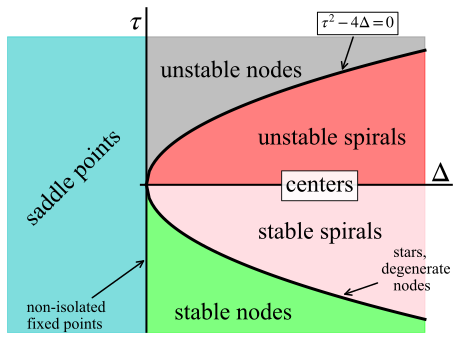

In [23]:
# FPs in a 2D linear system 
fig_FP, ax=plt.subplots(figsize=(8,6))
# x = delta; y=tau
yM = 2.2
x_ = np.linspace(0,1,100)
y_ = 2*np.sqrt(x_)
ax.plot(x_,y_,'k-',lw=3)
ax.plot(x_,-y_,'k-',lw=3)
ax.fill_between(x_,y_,color='red',alpha=0.5)
ax.fill_between(x_,-y_,color='pink',alpha=0.5)
ax.fill_between(x_,yM,y_,color='gray',alpha=0.5)
ax.fill_between(x_,-y_,-yM,color='lime',alpha=0.5)
ax.fill_between([-0.5,0],yM,-yM,color='c',alpha=0.5)
ax.axhline(0,0.3,1.1,c='k',ls='-',lw=2)
ax.axvline(0,-yM,yM*1.2,c='k',ls='-',lw=2)
ax.set_xlim(-0.5,1.1)
ax.set_ylim(-yM,yM*1.2)
ax.axis(False)

fs=28; fs1=24; fs2=16
ax.text(-0.06,yM*1.05,r'$\tau$',fontsize=fs)
ax.text(1.02,0.05,r'$\Delta$',fontsize=fs)
ax.text(0.5,-0.1,'centers',bbox=dict(ec='k',fc='w',alpha=0.9),fontsize=fs1)
ax.text(0.4,0.6,'unstable spirals',bbox=dict(ec='w',fc='w',alpha=0),fontsize=fs1)
ax.text(0.4,-0.8,'stable spirals',bbox=dict(ec='w',fc='w',alpha=0),fontsize=fs1)
ax.text(0.05,1.6,'unstable nodes',bbox=dict(ec='w',fc='w',alpha=0),fontsize=fs1)
ax.text(0.1,-2,'stable nodes',bbox=dict(ec='w',fc='w',alpha=0),fontsize=fs1)
ax.text(-0.45,-0.6,'saddle points',rotation=45,fontsize=fs1)
ax.annotate(r'$\tau^2-4\Delta=0$',
            xy=(0.7,2*np.sqrt(0.7)),xycoords='data',
            xytext=(-20,45),textcoords='offset points',
            arrowprops=dict(arrowstyle='->',lw=1.5),fontsize=fs2,bbox=dict(fc='w',ec='k'))
ax.annotate('non-isolated\nfixed points',
            xy=(0,-1.1),xycoords='data',
            xytext=(-120,-70),textcoords='offset points',
            arrowprops=dict(arrowstyle='->',lw=1.5),fontsize=fs2)
ax.annotate('   stars,\ndegenerate\n   nodes',
            xy=(0.7,-2*np.sqrt(0.7)+0.03),xycoords='data',
            xytext=(40,5),textcoords='offset points',
            arrowprops=dict(arrowstyle='->',lw=1.5),fontsize=fs2)
# fig_FP.savefig('FIGS/FP_L2D_sys.pdf')
plt.show()

Cosider $\dot{X}=A\cdot X$, with $A = \begin{pmatrix} 0 & -1  \\ \Delta & \tau  \\ \end{pmatrix}$ 

In [24]:
# phase portrait
x1 = -10; x2 = 10
y1 = -10; y2 = 10

d0=2; col='k'
dx0=1; dy0=1
ppx = np.arange(x1,x2,dx0)
ppy = np.arange(y1,y2,dy0)
pp1 = np.ones(len(ppx))

@interact(delta=(-3,3,0.5),tau=(-3,3,0.5),grid=True)
def update(delta=0,tau=0,grid=True):

    f1 = lambda x,y: -y 
    f2 = lambda x,y: delta*x+tau*y
    mu,U=lg.eig(np.array([[0,-1],[delta,tau]]))
    pv1 = U[:,0].reshape([2,1])/20.
    pv2 = U[:,1].reshape([2,1])/10.

    fig_FP, ax = plt.subplots(figsize=(5,5))
    if tau==0:
        PP_2d_sp(x1,x2,y1,y2,f1,f2,np.array([ppx*0,ppx]),ax,col=col,dens=d0)
        PP_2d_sp(x1,x2,y1,y2,f1,f2,np.array([ppx,ppx*0]),ax,col=col,dens=d0)
    elif delta==0:
        PP_2d_sp(x1,x2,y1,y2,f1,f2,np.array([ppx,pp1*0.01]),ax,col=col,dens=d0)
        PP_2d_sp(x1,x2,y1,y2,f1,f2,np.array([ppx,-pp1*0.01]),ax,col=col,dens=d0)
    else:    
        PP_2d_sp(x1,x2,y1,y2,f1,f2,np.array([ppx,pp1*8]),ax,col=col,dens=d0)
        PP_2d_sp(x1,x2,y1,y2,f1,f2,np.array([ppx,-pp1*8]),ax,col=col,dens=d0)
# streamlines through the eigendirections
    PP_evd(x1,x2,y1,y2,f1,f2,[0,0],ax)

    ax.set_aspect('equal')
    ax.set_xlim(x1,x2)
    ax.set_ylim(y1,y2)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.grid(grid)
    ax.text(0.,1.05,r'$\tau =$'+str(tau),fontsize=20,transform=ax.transAxes )
    ax.text(0.3,1.05,r'$\Delta =$'+str(delta),fontsize=20,transform=ax.transAxes)
    ax.text(0.6,1.05,r'$\tau^2-4\Delta =$'+str(tau**2-4*delta),fontsize=20,transform=ax.transAxes)
    plt.show()

interactive(children=(FloatSlider(value=0.0, description='delta', max=3.0, min=-3.0, step=0.5), FloatSlider(va…

$A = \begin{pmatrix} \lambda_1 & b  \\ 0 & \lambda_2  \\ \end{pmatrix} \; \Rightarrow \; 
\tau=\lambda_1+\lambda_2,\;
\Delta=\lambda_1 \lambda_1,\;$
and $\; \tau^2-4\Delta=(\lambda_1-\lambda_2)^2 \ge 0 $ 

In [25]:
# phase portrait 2 

x1 = -10; x2 = 10
y1 = -10; y2 = 10

d0=2; col='k'
dx0=1; dy0=1
ppx = np.arange(x1,x2,dx0)
ppy = np.arange(y1,y2,dy0)
pp1 = np.ones(len(ppx))

@interact(µ1=(-3,3,0.5),µ2=(-3,3,0.5),b=(-1,1,0.2),grid=True)
def update(µ1=0,µ2=0,b=0,grid=True):

    f1 = lambda x,y: µ1*x+b*y 
    f2 = lambda x,y: µ2*y
    mu,U=lg.eig(np.array([[µ1,b],[0,µ2]]))
    pv1 = U[:,0].reshape([2,1])/10.
    pv2 = U[:,1].reshape([2,1])/10.
    tau = µ1+µ2
    delta = µ1*µ2
    fig_FP, ax = plt.subplots(figsize=(5,5))

#     PP_2d(x1,x2,y1,y2,f1,f2,ax,col=col,dens=d0)
    PP_2d_sp(x1,x2,y1,y2,f1,f2,np.array([ppx,pp1*y1]),ax,col=col,dens=d0)
    PP_2d_sp(x1,x2,y1,y2,f1,f2,np.array([ppx,pp1*y2]),ax,col=col,dens=d0)
    PP_2d_sp(x1,x2,y1,y2,f1,f2,np.array([pp1*x1,ppx]),ax,col=col,dens=d0)
    PP_2d_sp(x1,x2,y1,y2,f1,f2,np.array([pp1*x2,ppx]),ax,col=col,dens=d0)
    
# streamlines through the eigendirections
    PP_evd(x1,x2,y1,y2,f1,f2,[0,0],ax)

    ax.set_aspect('equal')
    ax.set_xlim(x1,x2)
    ax.set_ylim(y1,y2)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.grid(grid)
    ax.text(0,1.05,r'$\tau =$'+str(tau)+';',fontsize=20,transform=ax.transAxes )
    ax.text(0.35,1.05,r'$\Delta =$'+str(delta)+';',fontsize=20,transform=ax.transAxes)
    ax.text(0.7,1.05,r'$\tau^2-4\Delta =$'+str((µ1-µ2)**2),fontsize=20,transform=ax.transAxes)
    plt.show()

interactive(children=(FloatSlider(value=0.0, description='μ1', max=3.0, min=-3.0, step=0.5), FloatSlider(value…

## 5.3 Love affair (coupled two component system)

The love affair between Romeo (R) and Juliet (J) is described by the linear 2D dynamical system

$\dot{R} = a R + b J\\$  $\dot{J} = c R + d J$

$R,R>0$ ($<0$) signifies _love_ (_hate_), while zero means _indifference_. 

### symbolic calculations

In [26]:
a,b,c,d = sp.symbols('a,b,c,d',real=True)
# define system matrix
A_RJ = sp.Matrix([[a,b],[c,d]])
display(A_RJ)
# find trace and determinant
tr_  = A_RJ.trace()
det_ = A_RJ.det()
display(Latex(r'$\tau = Tr   (A)={} , \; \Delta = det(A) = {}$'.format(sp.latex(tr_),sp.latex(det_))))

Matrix([
[a, b],
[c, d]])

<IPython.core.display.Latex object>

In [27]:
# find eigenvalues and eigenvectors
eig_sys = A_RJ.eigenvects()
mu_RJ = [elem[0] for elem in eig_sys];
V_RJ  = [elem[2][0] for elem in eig_sys];
# L_  = sp.diag(mu_,unpack=True);
# U_  = sp.Matrix([sp.flatten(v) for v in V_]);

In [28]:
display(mu_RJ[1])
mu_RJ[1]==((tr_+sp.sqrt(tr_**2-4*det_)).expand())/2

a/2 + d/2 + sqrt(a**2 - 2*a*d + 4*b*c + d**2)/2

True

### Phase portrait

In [29]:
# phase portrait
x1 = -10; x2 = 10
y1 = -10; y2 = 10
tt = np.linspace(0,5,50)

d0=2; col='k'
dx0=2
ppx = np.arange(x1,x2,dx0)
pp1 = np.ones(len(ppx))

@interact(a=(-3,3,0.5),b=(-3,3,0.5),c=(-3,3,0.5),d=(-3,3,0.5),grid=True)
def update(a=0,b=1,c=-1,d=1,grid=True):

    f1 = lambda x,y: a*x+b*y 
    f2 = lambda x,y: c*x+d*y
    mu,U=lg.eig(np.array([[a,b],[c,d]]))
    tau = a+d; delta=a*d-b*c
    pv1 = U[:,0].reshape([2,1])/10.
    pv2 = U[:,1].reshape([2,1])/10.

    fig_RJ, ax = plt.subplots(figsize=(5,5))

    PP_2d_sp(x1,x2,y1,y2,f1,f2,np.array([ppx,pp1*y1]),ax,col=col,dens=d0)
    PP_2d_sp(x1,x2,y1,y2,f1,f2,np.array([ppx,pp1*y2]),ax,col=col,dens=d0)
    PP_2d_sp(x1,x2,y1,y2,f1,f2,np.array([pp1*x1,ppx]),ax,col=col,dens=d0)
    PP_2d_sp(x1,x2,y1,y2,f1,f2,np.array([pp1*x2,ppx]),ax,col=col,dens=d0)
    
# streamlines through the eigendirections
    PP_evd(x1,x2,y1,y2,f1,f2,[0,0],ax)

    ax.set_aspect('equal')
    ax.set_xlim(x1,x2)
    ax.set_ylim(y1,y2)
    ax.set_xlabel('$R$')
    ax.set_ylabel('$J$')
    ax.grid(grid)
    ax.text(0.,1.05,r'$\tau =$'+str(tau)+';',fontsize=20,transform=ax.transAxes )
    ax.text(0.3,1.05,r'$\Delta =$'+str(delta)+';',fontsize=20,transform=ax.transAxes)
    ax.text(0.6,1.05,r'$\tau^2-4\Delta =$'+str(tau**2-4*delta),fontsize=20,transform=ax.transAxes)
#  uncomment below for P_5.3.2
# # {R(t),J(t)} trajectory ...    
#     PP_2d_sp(x1,x2,y1,y2,f1,f2,np.array([[1],[0]]),ax,col='b',lw=3,dens=d0)
# # ... for initial condition {R(0),J(0)}=(1,0)   
#     ax.plot([1],[0],'ro',ms=10,mfc='w',mec='r',lw=2)

plt.show()

interactive(children=(FloatSlider(value=0.0, description='a', max=3.0, min=-3.0, step=0.5), FloatSlider(value=…